# DeepEyeNet-Image Captioning with key word reinforced
## Evaluation Part

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import json
import os
import re
import pickle
from tqdm import tqdm
from collections import defaultdict
import nltk
import h5py
import warnings
warnings.filterwarnings('ignore')
from nltk.translate.bleu_score import sentence_bleu

from keras.optimizers import Adam, RMSprop
from keras.models import load_model

from model.model import CaptionModel
from model.model_k import MeanModel
from utils import *

# 1. Load Data

In [3]:
# train_imgs, val_imgs, test_imgs
train_imgs = load_pickle('./data/data_path/train_imgs.pkl')
val_imgs = load_pickle('./data/data_path/val_imgs.pkl')
test_imgs = load_pickle('./data/data_path/test_imgs.pkl')

# imgs features
train_imgs_features = load_pickle('./data/img_features/train_imgs_features_vgg_sub.pkl')
val_imgs_features = load_pickle('./data/img_features/val_imgs_features_vgg_sub.pkl')
test_imgs_features = load_pickle('./data/img_features/test_imgs_features_vgg_sub.pkl')

# Important features
results = load_pickle('./data/data_path/results.pkl')

In [4]:
# Parameters
vocab_size = len(results['word2id'])
max_len = max([len(x) for x in results['cap_toks'].values()])
embedding_size = 300
new_vocab_size = len(results['word2id_keys'])
key_max_len = max([len(x) for x in results['keywords_ids'].values()])

param = {}

param["key_max_len"] = key_max_len
param["keywords_ids"] = results['keywords_ids']
param["embedding_size"] = embedding_size
param["vocab_size"] = new_vocab_size
param["max_len"] = max_len
param["word2id"] = results["word2id"]
param["id2word"] = results["id2word"]

In [5]:
# MODEL (No keywords)
model_obj = CaptionModel(embedding_size, vocab_size, max_len, results['word2id'], results['id2word'])
final_model = model_obj.forward()
final_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
final_model = load_model('./checkpoints/model_vgg_new_e3.h5')

In [6]:
# MODEL (With keywords)
model_obj_k = MeanModel(param)
final_model_k = model_obj_k.forward()
final_model_k.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
final_model_k = load_model('./checkpoints/model_vgg_new_keywords_e3.h5')

# 2. Evaluation

In [7]:
def text_prepare(text):
    """
        text: a string

        return: modified string tokens 
                [tok1, tok2 , ...] which is a single sentence from one character
    """
    REPLACE_BY_SPACE_RE = re.compile('[-(){}\[\]\|@;]')
    BAD_SYMBOLS_RE = re.compile('[#+_]')
    mxlen = 50

    tok = []
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)
    text = re.sub(BAD_SYMBOLS_RE, '', text)
    tok += text.split(" ")
    if len(tok) > mxlen:
        tok = tok[:mxlen]

    return " ".join(tok)

In [8]:
def predict_captions(imgs, imgs_feats, model, obj, key_flag):
    gts, res = {}, {}
    for i,img in tqdm(enumerate(imgs)):
        if key_flag:
            predicted = text_prepare(obj.predict_captions_k(img, imgs_feats, model))
        else:
            predicted = text_prepare(obj.predict_captions(img, imgs_feats, model))
        ground_truth = text_prepare(results['descriptions'][img])
        
        # ground truth
        if img not in gts:
            gts[img] = [ground_truth]
        else:
            gts[img] = [gts[img], ground_truth]
        if img not in res:
            res[img] = [predicted]
        else:
            res[img] = [res[img], predicted]
        
    return gts, res

In [15]:
train_gts, train_res = predict_captions(train_imgs, train_imgs_features, final_model, model_obj, 0)

1567it [16:38,  1.57it/s]


In [16]:
test_gts, test_res = predict_captions(test_imgs, test_imgs_features, final_model, model_obj, 0)

196it [01:45,  1.86it/s]


In [17]:
train_gts_k, train_res_k = predict_captions(train_imgs, train_imgs_features, final_model_k, model_obj_k, 1)

1567it [14:47,  1.77it/s]


In [18]:
test_gts_k, test_res_k = predict_captions(test_imgs, test_imgs_features, final_model_k, model_obj_k, 1)

196it [01:40,  1.96it/s]


In [20]:
save_json(train_gts, 'results/train_gts.json')
save_json(train_res, 'results/train_res.json')
save_json(test_gts, 'results/test_gts.json')
save_json(test_res, 'results/test_res.json')
save_json(train_gts_k, 'results/train_gts_k.json')
save_json(train_res_k, 'results/train_res_k.json')
save_json(test_gts_k, 'results/test_gts_k.json')
save_json(test_res_k, 'results/test_res_k.json')

In [9]:
from utils import *
train_gts = load_json('results/train_gts.json')
train_res = load_json('results/train_res.json')
test_gts = load_json('results/test_gts.json')
test_res = load_json('results/test_res.json')
train_gts_k = load_json('results/train_gts_k.json')
train_res_k = load_json('results/train_res_k.json')
test_gts_k = load_json('results/test_gts_k.json')
test_res_k = load_json('results/test_res_k.json')

## A. Bleu Score

In [10]:
def evaluate_bleu(imgs, imgs_feats, model, obj, key_flag):
    
    avgscore = 0

    for i in tqdm(range(len(imgs))):
        if key_flag:
            predicted = obj.predict_captions_k(imgs[i], imgs_feats, model)
        else:
            predicted = obj.predict_captions(imgs[i], imgs_feats, model)
        ground_truth = results['descriptions'][imgs[i]]
        predicted_tok = obj.text_prepare(predicted)
        ground_truth_tok = [obj.text_prepare(ground_truth)]
        
        avgscore += sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))
    
    avgscore /= len(imgs)
    return avgscore

In [11]:
def evaluate_bleu_bs(imgs, imgs_feats, model, obj, key_flag):
    
    avgscore = 0

    for i in tqdm(range(len(imgs))):
        if key_flag:
            predicted = obj.predict_captions_beam_search_k(imgs[i], imgs_feats, model)
        else:
            predicted = obj.predict_captions_beam_search(imgs[i], imgs_feats, model)
        ground_truth = results['descriptions'][imgs[i]]
        predicted_tok = obj.text_prepare(predicted)
        ground_truth_tok = [obj.text_prepare(ground_truth)]
        
        avgscore += sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))
    
    avgscore /= len(imgs)
    return avgscore

### 1) Final model without keywords

Predicted Caption: 60 year old white male. srnv md. 20/200 and 20/70.
Ground Truth Caption: 60-year-old white male. srnv-md. 20/200 and 20/50.
Bleu Score 1: 0.9166666666666666
Bleu Score 2: 0.8181818181818182
Bleu Score 3: 0.8
Bleu Score 4: 0.7777777777777778


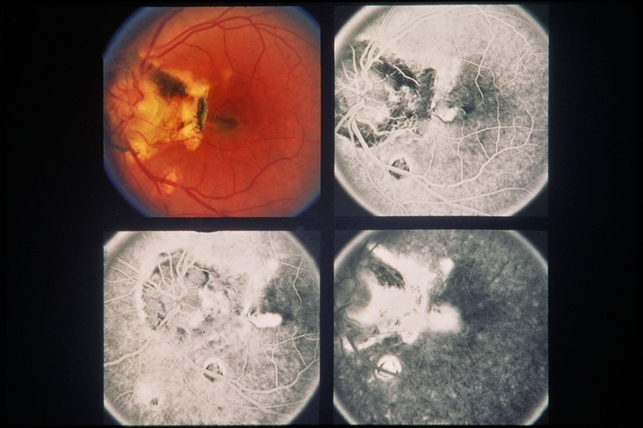

In [16]:
# final_model without keywords bleu score Example
train_id = 310
print('Predicted Caption: {}'.format(model_obj.predict_captions(train_imgs[train_id], train_imgs_features, final_model)))
print('Ground Truth Caption: {}'.format(results['descriptions'][train_imgs[train_id]]))

predicted = model_obj.predict_captions(train_imgs[train_id], train_imgs_features, final_model)
ground_truth = results['descriptions'][train_imgs[train_id]]
predicted_tok = model_obj.text_prepare(predicted)
ground_truth_tok = [model_obj.text_prepare(ground_truth)]

# Bleu Score Calculation
print('Bleu Score 1: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))))
print('Bleu Score 2: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 1, 0, 0))))
print('Bleu Score 3: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 1, 0))))
print('Bleu Score 4: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 0, 1))))

Image.open(train_imgs[train_id]+'.jpg')

In [28]:
train_bleu = evaluate_bleu(train_imgs, train_imgs_features, final_model, model_obj, 0)
train_bleu

100%|██████████| 1567/1567 [16:52<00:00,  1.55it/s]


0.8691786596490183

In [29]:
test_bleu = evaluate_bleu(test_imgs, test_imgs_features, final_model, model_obj, 0)
test_bleu

100%|██████████| 196/196 [02:05<00:00,  1.56it/s]


0.687886285893347

### Beam Search Score

In [17]:
# final_model without keywords bleu score Example
train_id = 332
print('Predicted Caption: {}'.format(model_obj.predict_captions_beam_search(train_imgs[train_id], train_imgs_features, final_model)))
print('Ground Truth Caption: {}'.format(results['descriptions'][train_imgs[train_id]]))

predicted = model_obj.predict_captions(train_imgs[train_id], train_imgs_features, final_model)
ground_truth = results['descriptions'][train_imgs[train_id]]
predicted_tok = model_obj.text_prepare(predicted)
ground_truth_tok = [model_obj.text_prepare(ground_truth)]
print('Bleu Score: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))))

Predicted Caption: 60 tear old male, giant confluent drusen.
Ground Truth Caption: 60-tear-old male, giant confluent drusen.
Bleu Score: 1.0


### ---------------------------------------
### 2) Final model with keywords

Predicted Caption: 60 year old white male. srnv md. 20/200 and 20/50.
Ground Truth Caption: 60-year-old white male. srnv-md. 20/200 and 20/50.
Bleu Score 1: 1.0
Bleu Score 2: 1.0
Bleu Score 3: 1.0
Bleu Score 4: 1.0


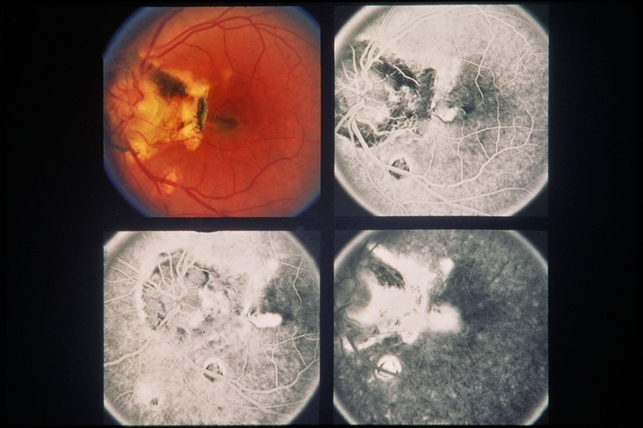

In [18]:
train_id = 310
print('Predicted Caption: {}'.format(model_obj_k.predict_captions_k(train_imgs[train_id], train_imgs_features, final_model_k)))
print('Ground Truth Caption: {}'.format(results['descriptions'][train_imgs[train_id]]))

predicted = model_obj_k.predict_captions_k(train_imgs[train_id], train_imgs_features, final_model_k)
ground_truth = results['descriptions'][train_imgs[train_id]]
predicted_tok = model_obj.text_prepare(predicted)
ground_truth_tok = [model_obj.text_prepare(ground_truth)]

# Bleu Score Calculation
print('Bleu Score 1: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))))
print('Bleu Score 2: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 1, 0, 0))))
print('Bleu Score 3: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 1, 0))))
print('Bleu Score 4: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 0, 1))))

Image.open(train_imgs[train_id]+'.jpg')

In [30]:
train_bleu_k = evaluate_bleu(train_imgs, train_imgs_features, final_model_k, model_obj_k, 1)
train_bleu_k

100%|██████████| 1567/1567 [16:14<00:00,  1.61it/s]


0.966367038527739

In [31]:
test_bleu_k = evaluate_bleu(test_imgs, test_imgs_features, final_model_k, model_obj_k, 1)
test_bleu_k

100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.7387285947720349

### Beam Search Score

In [32]:
train_id = 332
print('Predicted Caption: {}'.format(model_obj_k.predict_captions_beam_search_k(train_imgs[train_id], train_imgs_features, final_model_k)))
print('Ground Truth Caption: {}'.format(results['descriptions'][train_imgs[train_id]]))

predicted = model_obj_k.predict_captions_k(train_imgs[train_id], train_imgs_features, final_model_k)
ground_truth = results['descriptions'][train_imgs[train_id]]
predicted_tok = model_obj.text_prepare(predicted)
ground_truth_tok = [model_obj.text_prepare(ground_truth)]
print('Bleu Score: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))))

Predicted Caption: 60 tear old male, giant confluent drusen.
Ground Truth Caption: 60-tear-old male, giant confluent drusen.
Bleu Score: 1.0


## B. Cider, Rouge

In [12]:
from eval_tools import Cider, Rouge

def calc_scores(scorer, name):
    print('-----------------------------')
    print(name+':')
    (score, scores) = scorer.compute_score(train_gts, train_res)
    print('train %s score = %.4f' % (name,score))
    (score, scores) = scorer.compute_score(test_gts, test_res)
    print('test %s score = %.4f' % (name,score))
    (score, scores) = scorer.compute_score(train_gts_k, train_res_k)
    print('train %s score (key model) = %.4f' % (name,score))
    (score, scores) = scorer.compute_score(test_gts_k, test_res_k)
    print('test %s score (key model) = %.4f' % (name,score))

## C. Self-Defined Classifier

In [39]:
from eval_model import CLRScorer
candidate = ['diabetic retinopathy fundus image']
refs = ['diabetic retinopathy fundus image.']
scorer = CLRScorer('srnv-md')
score,label = scorer.calc_score(candidate, refs)

In [40]:
print(score)
print(label)

0.9874752759933472
['diabetic-retinopathy']


# 3. Comparison

In [13]:
# 1. Bleu Score Calculation
print("Average Bleu score for original model with train imgs: %.4f" % train_bleu)
print("Average Bleu score for original model with test imgs: %.4f" % test_bleu)
print("Average Bleu score for keyword model with train imgs: %.4f" % train_bleu_k)
print("Average Bleu score for keyword model with test imgs: %.4f" % test_bleu_k)

Average Bleu score for original model with train imgs: 0.8692
Average Bleu score for original model with test imgs: 0.6879
Average Bleu score for keyword model with train imgs: 0.9664
Average Bleu score for keyword model with test imgs: 0.7387


In [16]:
# 2. CIDEr, Meteor, Rouge, Spice
calc_scores(Cider(), 'cider')
calc_scores(Rouge(), 'rouge')

-----------------------------
cider:
train cider score = 6.3607
test cider score = 3.5747
train cider score (key model) = 8.3280
test cider score (key model) = 4.6886
-----------------------------
rouge:
train rouge score = 0.8633
test rouge score = 0.6532
train rouge score (key model) = 0.9672
test rouge score (key model) = 0.7127


# 4. Testing Results

In [39]:
def test(idds, imgs, imgs_features, model, model_obj, train_gts, train_res):
    #Cider & Rouge
    (score, scores) = Cider().compute_score(train_gts, train_res)
    print('Cider score = %.4f' % (score))
    (score, scores) = Rouge().compute_score(train_gts, train_res)
    print('Rouge score = %.4f' % (score))
    
    for idd in idds:
        print("\n========Image Id: {}========".format(idd))
        predicted = model_obj.predict_captions(imgs[idd], imgs_features, model)
        ground_truth = results['descriptions'][imgs[idd]]
        predicted_tok = model_obj.text_prepare(predicted)
        ground_truth_tok = [model_obj.text_prepare(ground_truth)]
        
        print('Predicted Caption: {}'.format(predicted))
        print('Ground Truth Caption: {}'.format(ground_truth))

        # Bleu Score Calculation
        print('Bleu Score 1: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))))
        print('Bleu Score 2: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 1, 0, 0))))
        print('Bleu Score 3: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 1, 0))))
        print('Bleu Score 4: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 0, 1))))

In [40]:
idds = np.random.randint(0,len(train_imgs),10)
train_gts, train_res = predict_captions(np.asarray(train_imgs)[idds], train_imgs_features, final_model, model_obj, 0)
test(idds, train_imgs, train_imgs_features, final_model, model_obj, train_gts, train_res)

10it [00:08,  1.16it/s]


Cider score = 7.0302
Rouge score = 0.9175

========Image Id: 455========
Predicted Caption: left eye fluorescein angiogram of a female year old female with loss of vision and vision of vision ou.
Ground Truth Caption: 55 -year-old female presented with complains of loss of vision ou.
Bleu Score 1: 0.5238095238095238
Bleu Score 2: 0.3
Bleu Score 3: 0.21052631578947367
Bleu Score 4: 0.05555555555555554

========Image Id: 475========
Predicted Caption: 66 year old white female. drusen.
Ground Truth Caption: 66-year-old white female. drusen.
Bleu Score 1: 1.0
Bleu Score 2: 1.0
Bleu Score 3: 1.0
Bleu Score 4: 1.0

========Image Id: 795========
Predicted Caption: fundus of an 82 year male complaining of distortion of images for 7 for smooth edges suggestive of macular dystrophy.  visual acuity was 20/40 each eye.  family history was not significant.
Ground Truth Caption: fundus of an 82-year-male complaining of distortion of images for 7 years. bilateral raised circular hypopigmented lesion 